# Superheroes

![Superheroes](https://image.winudf.com/v2/image/Y29tLmRvdWJsZWtpbGwuYWNfc2NyZWVuc2hvdHNfMF9kNWIzNTRlMw/screen-0.jpg?fakeurl=1&type=.jpg)

## Motivation

There are thousands of superheroes in the superhero world and each superhero has their unique set of abilities, backstory and personality. This can make it overwhelming for someone who is just entering this world and it would be helpful if the user can get personalized superhero recommendations to explore those superheroes which resonate strongly with him.

# 1.0: Load Dataset

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from copy import copy
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import plotly.io as pio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [2]:
# Ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Load dataset
df_supes = pd.read_csv('superheroes_nlp_dataset.csv')
df_supes.head()

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hil...,NaN,100,20,30,50,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,100,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,40,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_supes.columns

Index(['name', 'real_name', 'full_name', 'overall_score', 'history_text',
       'powers_text', 'intelligence_score', 'strength_score', 'speed_score',
       'durability_score', 'power_score', 'combat_score', 'superpowers',
       'alter_egos', 'aliases', 'place_of_birth', 'first_appearance',
       'creator', 'alignment', 'occupation', 'base', 'teams', 'relatives',
       'gender', 'type_race', 'height', 'weight', 'eye_color', 'hair_color',
       'skin_color', 'img', 'has_electrokinesis', 'has_energy_constructs',
       'has_mind_control_resistance', 'has_matter_manipulation',
       'has_telepathy_resistance', 'has_mind_control', 'has_enhanced_hearing',
       'has_dimensional_travel', 'has_element_control', 'has_size_changing',
       'has_fire_resistance', 'has_fire_control', 'has_dexterity',
       'has_reality_warping', 'has_illusions', 'has_energy_beams',
       'has_peak_human_condition', 'has_shapeshifting', 'has_heat_resistance',
       'has_jump', 'has_self-sustenance', 'ha

# 1.2: Data Cleaning

In [5]:
# Dropping columns not required
df_supes = df_supes.drop(['real_name', 'full_name', 'alter_egos', 'aliases', 'place_of_birth', 
                         'first_appearance', 'occupation', 'base', 'relatives',
                         'gender', 'type_race', 'height', 'weight', 'eye_color', 'hair_color',
                         'skin_color', 'img'], axis=1)

In [6]:
df_supes.isna().sum()

name                    2
overall_score           0
history_text           90
powers_text           364
intelligence_score      0
                     ... 
has_super_speed        67
has_durability         67
has_stamina            67
has_agility            67
has_super_strength     67
Length: 64, dtype: int64

In [7]:
# Cleaning up data by assigning "Unknown" to NaN strings
df_supes['name'] = df_supes['name'].replace(np.nan, 'Unknown')
df_supes['powers_text'] = df_supes['powers_text'].replace(np.nan, 'Unknown')
df_supes['history_text'] = df_supes['history_text'].replace(np.nan, 'Unknown')
df_supes['creator'] = df_supes['creator'].replace(np.nan, 'Unknown')
df_supes['alignment'] = df_supes['alignment'].replace(np.nan, 'Unknown')

In [8]:
# Replacing special characters with NaN values
df_supes['overall_score'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_supes['overall_score'].replace('∞', np.nan, inplace=True)
df_supes['overall_score'].replace('-', np.nan, inplace=True)

In [9]:
# Dropping superheroes with NaN values for superpowers
df_supes = df_supes.dropna()

In [10]:
df_supes.isna().sum()

name                  0
overall_score         0
history_text          0
powers_text           0
intelligence_score    0
                     ..
has_super_speed       0
has_durability        0
has_stamina           0
has_agility           0
has_super_strength    0
Length: 64, dtype: int64

In [11]:
# Resetting the index column
df_supes = df_supes.reset_index(drop=True)

In [12]:
df_supes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name                              1316 non-null   object 
 1   overall_score                     1316 non-null   object 
 2   history_text                      1316 non-null   object 
 3   powers_text                       1316 non-null   object 
 4   intelligence_score                1316 non-null   int64  
 5   strength_score                    1316 non-null   int64  
 6   speed_score                       1316 non-null   int64  
 7   durability_score                  1316 non-null   int64  
 8   power_score                       1316 non-null   int64  
 9   combat_score                      1316 non-null   int64  
 10  superpowers                       1316 non-null   object 
 11  creator                           1316 non-null   object 
 12  alignm

## Data Exploration

### Total Power Column

In [13]:
# Summing up all the powers of each superhero
df_supes['all_powers'] = df_supes.sum(axis=1)

### Creating Smaller DataFrames

In [14]:
# Creating a smaller DataFrame for data visualization purposes
df_merge = df_supes[['name', 'creator', 'alignment', 'all_powers']]
df_merge

,name,creator,alignment,all_powers
0,3-D Man,Marvel Comics,Good,347.0
1,514A (Gotham),DC Comics,Unknown,338.0
2,A-Bomb,Marvel Comics,Good,562.0
3,Aa,DC Comics,Good,392.0
4,Aaron Cash,DC Comics,Good,237.0
...,...,...,...,...
1311,Zatanna,DC Comics,Good,313.0
1312,Zero,Capcom,Good,585.0
1313,Zoom (New 52),DC Comics,Bad,514.0
1314,Zoom,DC Comics,Bad,346.0


In [15]:
# Making DataFrame of superheroes of comic book creators
comic_supes = df_merge[df_merge['creator'].str.contains('Comics')==True]
comic_supes

,name,creator,alignment,all_powers
0,3-D Man,Marvel Comics,Good,347.0
1,514A (Gotham),DC Comics,Unknown,338.0
2,A-Bomb,Marvel Comics,Good,562.0
3,Aa,DC Comics,Good,392.0
4,Aaron Cash,DC Comics,Good,237.0
...,...,...,...,...
1309,Yukio (FOX),Marvel Comics,Good,324.0
1311,Zatanna,DC Comics,Good,313.0
1313,Zoom (New 52),DC Comics,Bad,514.0
1314,Zoom,DC Comics,Bad,346.0


In [16]:
comic_pivot = comic_supes.pivot_table(values='all_powers', index='creator', columns='alignment', aggfunc='mean')
comic_pivot = comic_pivot.replace(np.nan, 0)
comic_pivot

alignment,Bad,Good,Neutral,Unknown
creator,,,,
DC Comics,406.846667,393.148649,398.725000,396.142857
Dark Horse Comics,427.750000,366.777778,394.000000,0.000000
Icon Comics,192.000000,218.666667,0.000000,0.000000
Image Comics,567.500000,527.833333,0.000000,0.000000
Marvel Comics,381.172619,370.339041,446.222222,393.244444


In [17]:
score_data = df_supes[['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score']]
score_data.head()

,intelligence_score,strength_score,speed_score,durability_score,power_score,combat_score
0,85,30,60,60,40,70
1,100,20,30,50,35,100
2,80,100,80,100,100,80
3,80,50,55,45,100,55
4,80,10,25,40,30,50


### Creating Pivot Tables

In [18]:
# Making a pivot table showing the mean superpower value by creator and alignment
supes_pivot = df_supes.pivot_table(values=['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 
                             'power_score', 'combat_score'], index='creator', columns='alignment', aggfunc='mean')
supes_pivot = supes_pivot.replace(np.nan, 0)
supes_pivot.head()

combat_score                       durability_score  \
alignment                       Bad  Good Neutral Unknown              Bad   
creator                                                                      
ABC Studios                     0.0  12.5     0.0     0.0              0.0   
Blizzard Entertainment          0.0   0.0     0.0   100.0              0.0   
Capcom                        100.0  90.0   100.0   100.0             50.0   
Cartoon Network                 0.0  40.0    80.0     0.0              0.0   
Clive Barker                   25.0  50.0     0.0     0.0             80.0   

                                              intelligence_score        ...  \
alignment                Good Neutral Unknown                Bad  Good  ...   
creator                                                                 ...   
ABC Studios              27.5     0.0     0.0                0.0  80.0  ...   
Blizzard Entertainment    0.0     0.0    55.0                0.0   0.0  ...   
Capcom                  100.0    95.0    90.0              100.0  70.0  ...   
Cartoon Network          40.0    55.0     0.0                0.0  65.0  ...   
Clive Barker            100.0     0.0     0.0               90.0  90.0  ...   

                       power_score         speed_score                         \
alignment                  Neutral Unknown         Bad   Good Neutral Unknown   
creator                                                                         
ABC Studios                    0.0     0.0         0.0   25.0     0.0     0.0   
Blizzard Entertainment         0.0    65.0         0.0    0.0     0.0    70.0   
Capcom                       100.0   100.0        50.0  100.0    90.0    95.0   
Cartoon Network              100.0     0.0         0.0   25.0    20.0     0.0   
Clive Barker                   0.0     0.0        15.0   25.0     0.0     0.0   

                       strength_score                         
alignment                         Bad   Good Neutral Unknown  
creator                                                       
ABC Studios                       0.0   17.5     0.0     0.0  
Blizzard Entertainment            0.0    0.0     0.0    30.0  
Capcom                           50.0  100.0    80.0    75.0  
Cartoon Network                   0.0   10.0    10.0     0.0  
Clive Barker                     30.0   10.0     0.0     0.0  

[5 rows x 24 columns]

In [19]:
# Making a pivot table with the smaller DataFrame
merge_pivot = df_merge.pivot_table(values='all_powers', index='creator', columns='alignment', aggfunc='mean')
merge_pivot = merge_pivot.replace(np.nan, 0)
merge_pivot.head()

alignment,Bad,Good,Neutral,Unknown
creator,,,,
ABC Studios,0.0,194.25,0.0,0.0
Blizzard Entertainment,0.0,0.00,0.0,407.0
Capcom,475.0,585.50,570.0,570.0
Cartoon Network,0.0,255.00,380.0,0.0
Clive Barker,352.0,386.00,0.0,0.0


# 2.0: Data Visualization

In [20]:
# Define absolute path for saving figures
save_path = os.path.abspath('Charts')

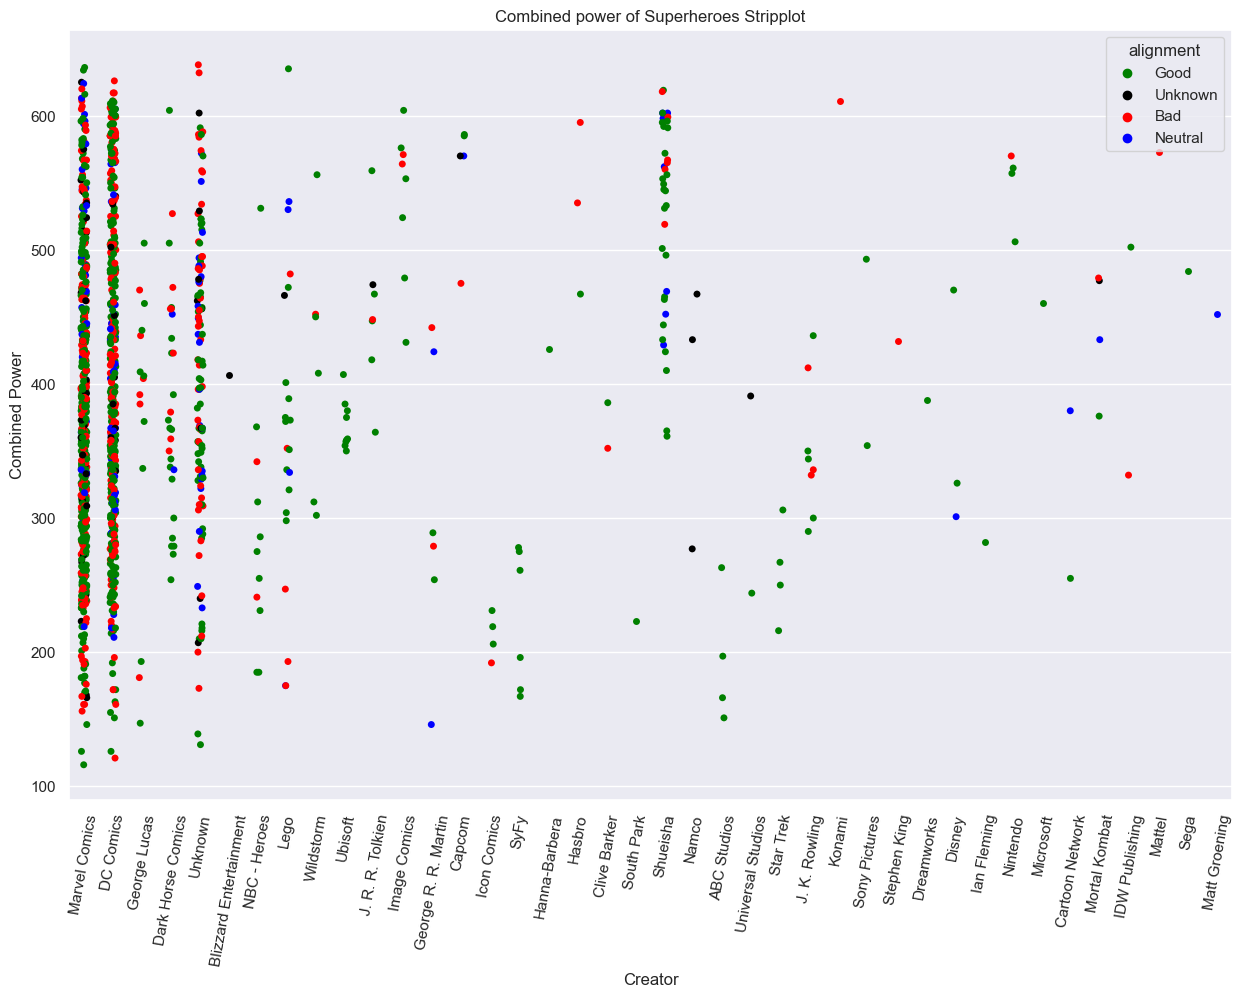

In [21]:
# Stripplot to show relationship between creator and combined power of superheroes of that creator by alignment
plt.figure(figsize=(15, 10))
plt.xticks(rotation=80)
sns.stripplot(data=df_merge, x='creator', y='all_powers', hue='alignment', palette=['green', 'black', 'red', 'blue']).set(title='Combined power of Superheroes Stripplot',
                                                                                                                          xlabel='Creator', ylabel='Combined Power')
# Save figure
plt.savefig(save_path + '/Stripp_Powers_Creators.jpg')

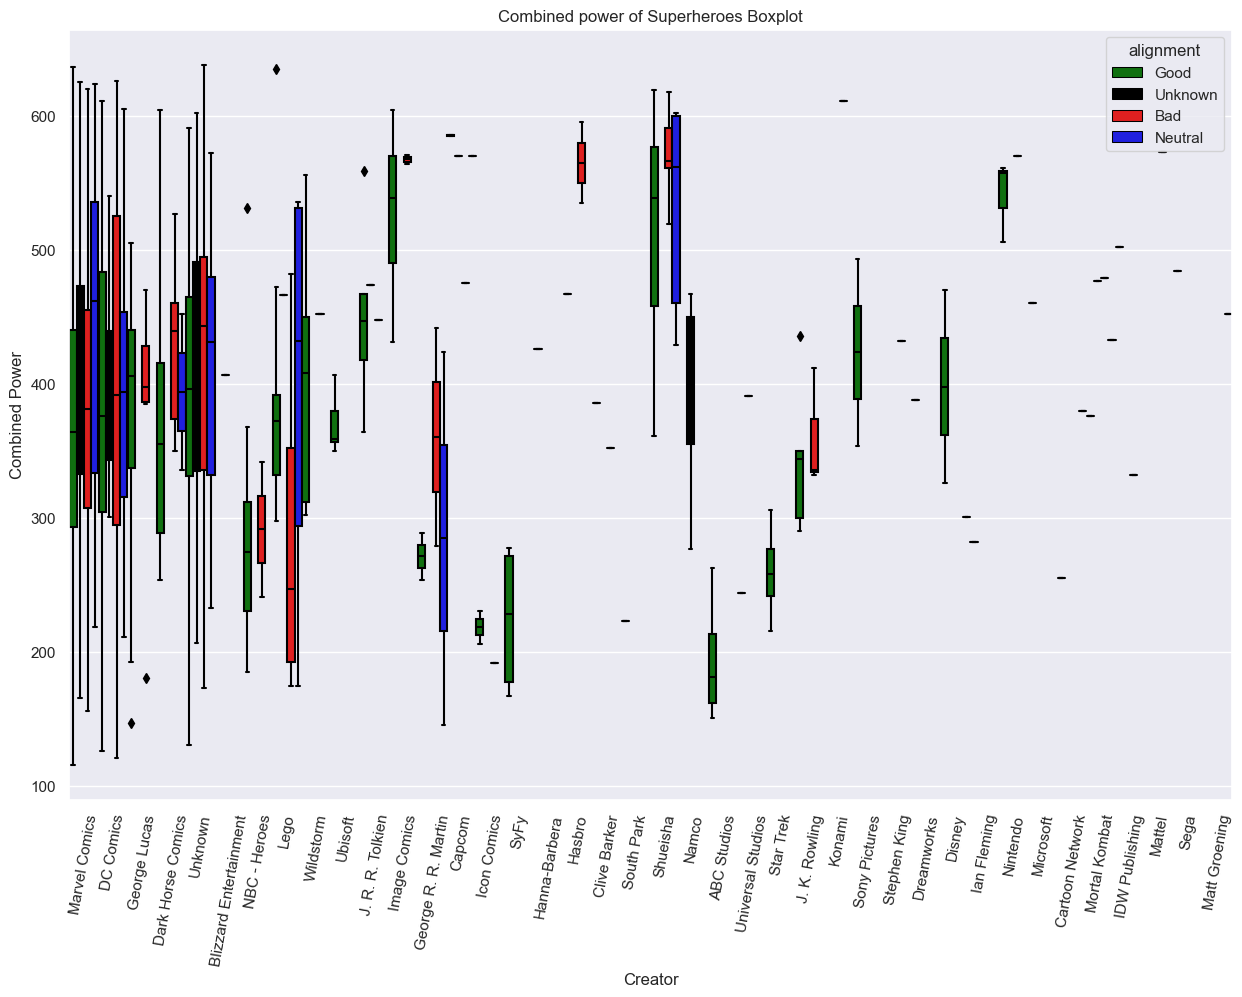

In [22]:
# Boxplot to show relationship between creator and combined power of superheroes of that creator by alignment
plt.figure(figsize=(15,10))
plt.xticks(rotation=80)
sns.boxplot(df_merge, x='creator', y='all_powers', hue='alignment', palette=['green', 'black', 'red', 'blue'], width=1).set(title='Combined power of Superheroes Boxplot',
                                                                                                                            xlabel='Creator', ylabel='Combined Power')
# Save figure
plt.savefig(save_path + '/Box_Powers_Creators.jpg')

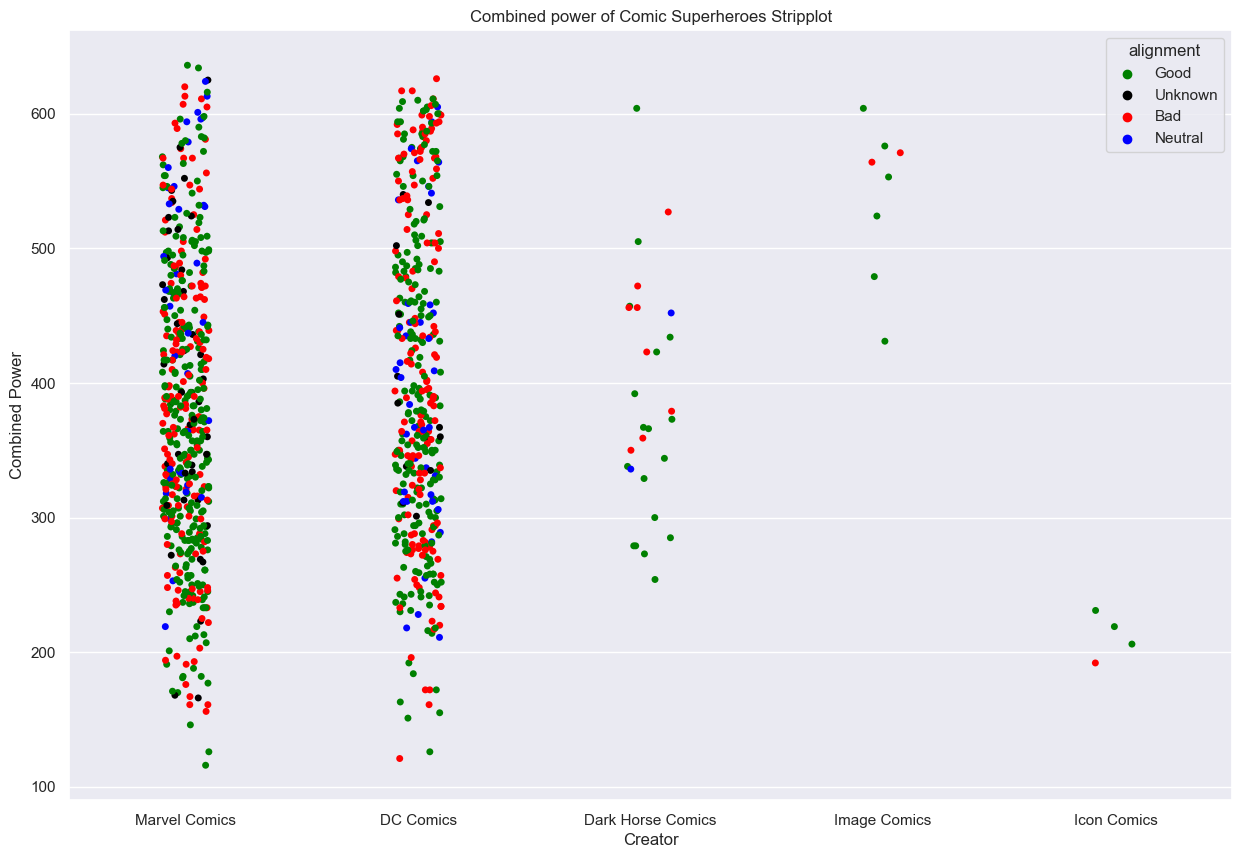

In [23]:
# Stripplot to show relationship between comic book creators and combined power of superheroes of that creator by alignment
plt.figure(figsize=(15, 10))
sns.stripplot(data=comic_supes, x='creator', y='all_powers', hue='alignment', palette=['green', 'black', 'red', 'blue']).set(title='Combined power of Comic Superheroes Stripplot',
                                                                                                                          xlabel='Creator', ylabel='Combined Power')
# Save figure
plt.savefig(save_path + '/Stripp_Powers_Comic_Creators.jpg')

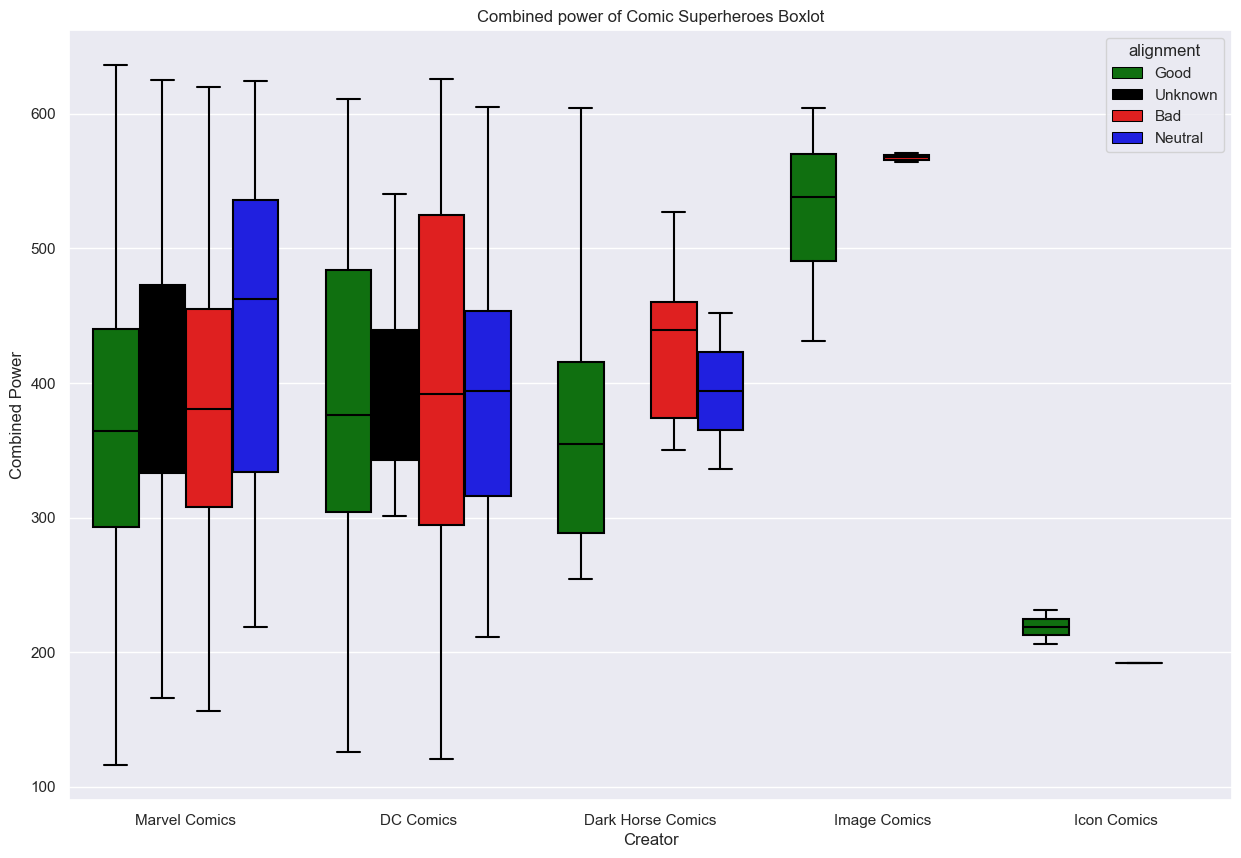

In [24]:
# Boxplot to show relationship between comic book creators and combined power of superheroes of that creator by alignment
plt.figure(figsize=(15, 10))
sns.boxplot(data=comic_supes, x='creator', y='all_powers', hue='alignment', palette=['green', 'black', 'red', 'blue']).set(title='Combined power of Comic Superheroes Boxlot',
                                                                                                                          xlabel='Creator', ylabel='Combined Power')
plt.savefig(save_path + '/Box_Powers_Comic_Creators.jpg')

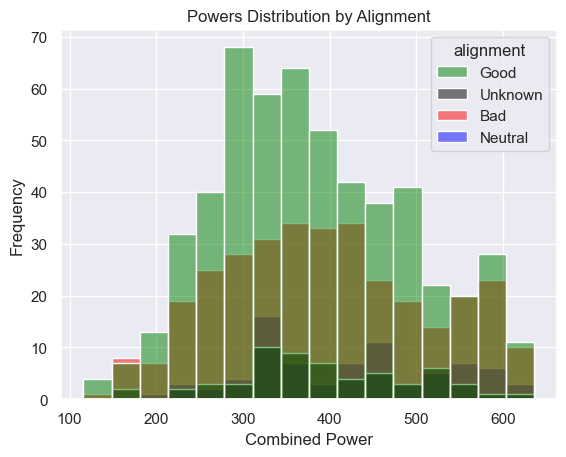

In [25]:
# Histplot to show the power distribution by alignment
sns.histplot(data=comic_supes, x='all_powers', hue='alignment', 
             palette=['green', 'black', 'red', 'blue']).set(title='Powers Distribution by Alignment', xlabel='Combined Power', ylabel='Frequency')
plt.savefig(save_path + '/Hist_Powers_Alignment.jpg')

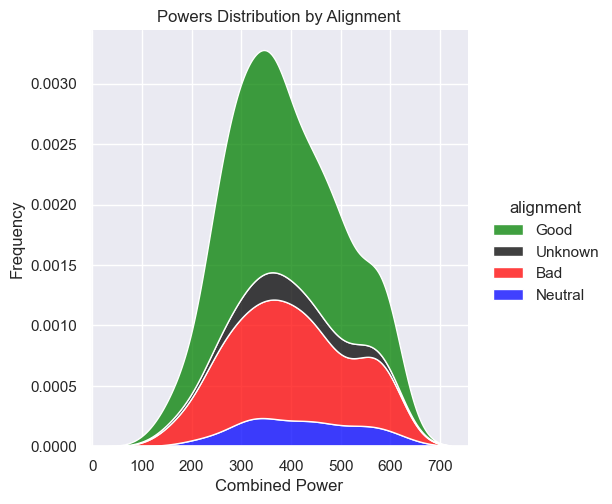

In [26]:
# Displot to show the power distribution by alignment
sns.displot(comic_supes, x='all_powers',hue='alignment', 
             palette=['green', 'black', 'red', 'blue'], kind="kde", multiple="stack").set(title='Powers Distribution by Alignment', xlabel='Combined Power', ylabel='Frequency')
plt.savefig(save_path + '/Dis_Powers_Alignment.jpg')

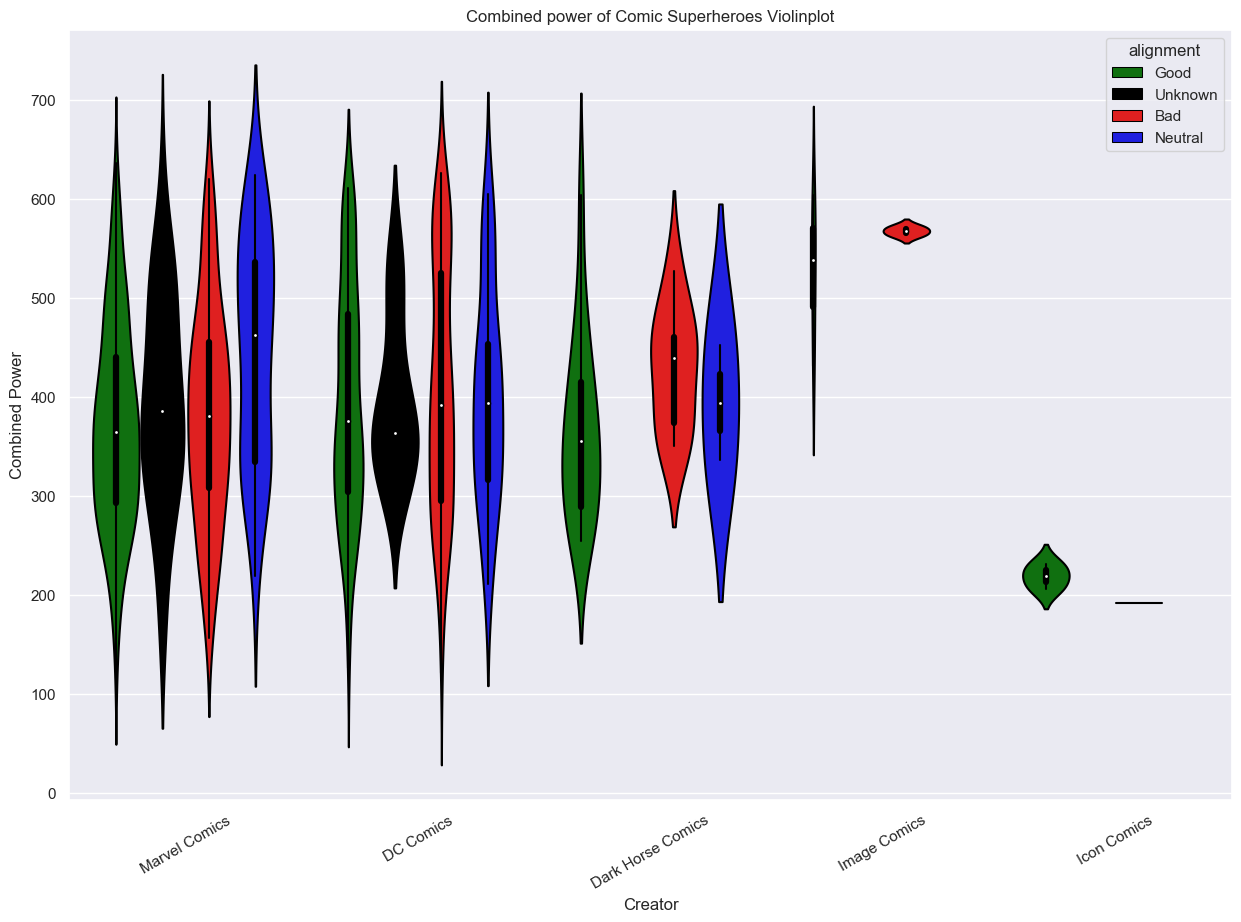

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(data=comic_supes, x="creator", y="all_powers", hue="alignment", palette=['green', 'black', 'red', 'blue']).set(title='Combined power of Comic Superheroes Violinplot',
                                                                                                                          xlabel='Creator', ylabel='Combined Power')
plt.xticks(rotation=30)

# Save figure
plt.savefig(save_path + "/Violinplot_Powers.jpg")

In [28]:
def correlation_plot():
    #correlation
    correlation = score_data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict(),)
    
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [29]:
# Heatmap to show correlation of scores between different powers
# correlation_plot()

![Plotly Heatmap](https://i.ibb.co/WPMnsBg/Screenshot-2023-04-18-164252.jpg)

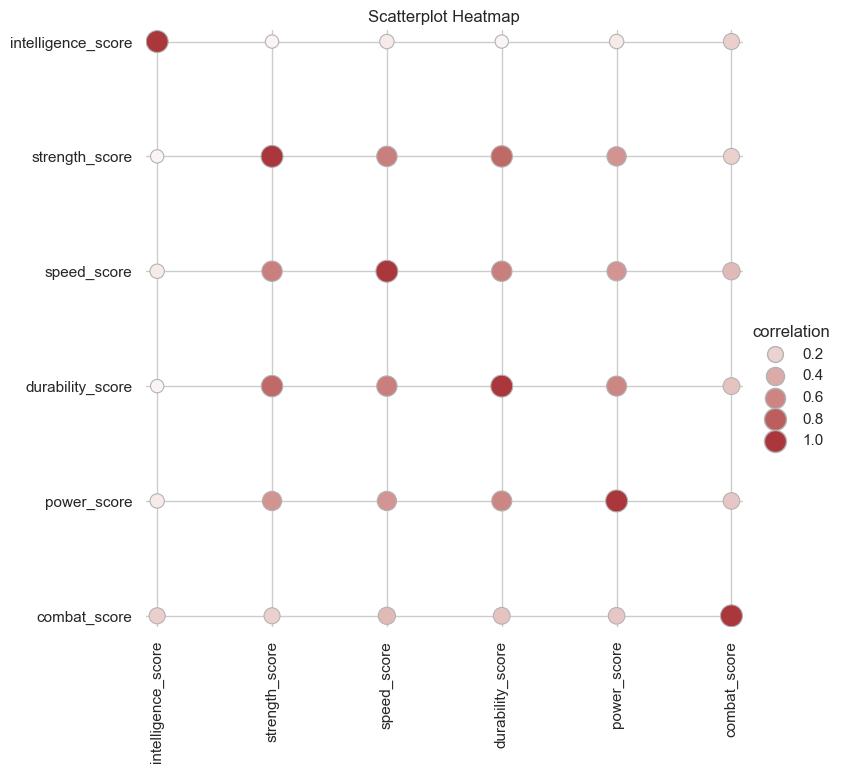

In [30]:
sns.set_theme(style="whitegrid")

df_heat = df_supes.loc[:, ['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score']]

# df_heat.columns = df_heat.columns.map("-".join)

# Compute a correlation matrix and convert to long-form
corr_mat = df_heat.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=8, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.title("Scatterplot Heatmap")

# Save figure
plt.savefig(save_path + "/Scatterplot_Heatmap_Scores.jpg")

# 3.0: Sentiment Analysis

In [31]:
#implement the sentiment score analyzer 
analyzer = SentimentIntensityAnalyzer()

scores_dict = dict()

# The history description of superheroes is used to calculate the sentiment score for each
df_supes['sentiment_score'] = df_supes['history_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
scores_dict = df_supes.set_index('name')['sentiment_score'].to_dict()

In [32]:
scores_list = list(scores_dict.values())
scores_list = [float(score) for score in scores_list]

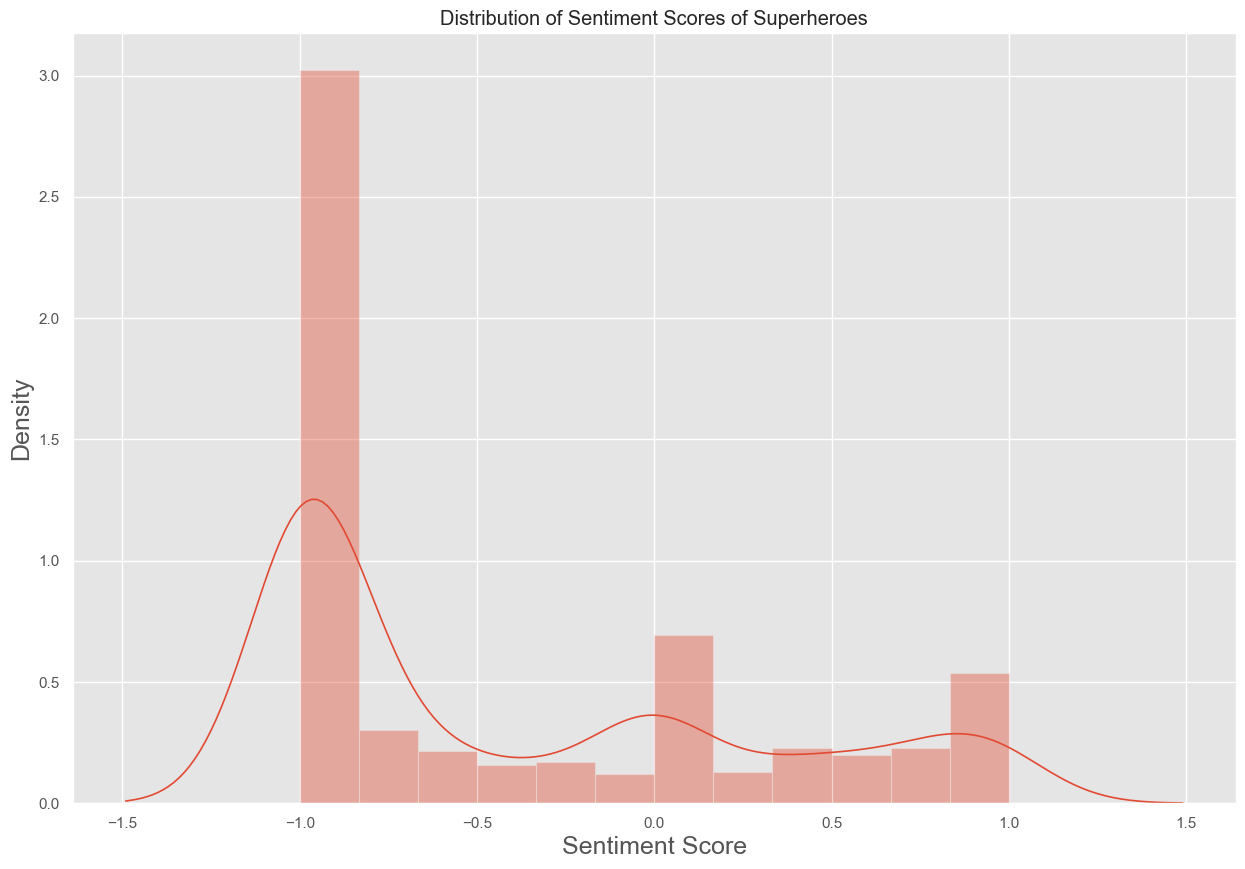

In [33]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
colors = ['#FFD700', '#7EC0EE']

# Visualizing the sentiment score distribution
sns.set_context("paper", font_scale=1.5)
f = sns.distplot(scores_list, kde=True);
f.set_xlabel("Sentiment Score",fontsize=18)
f.set_ylabel("Density",fontsize=18)
f.set_title('Distribution of Sentiment Scores of Superheroes')
plt.savefig(save_path + '/Sentiment_Distribution.jpg')

# 4.0: Dimensionality Reduction (PCA) 

In [34]:
# Perform PCA with quantative features to group 
x_feat_list = ['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score']
x_vals = df_supes.loc[:,x_feat_list].values

In [35]:
# Use PCA to fit and transform the features
pca = PCA()
pca.fit_transform(x_vals)

array([[ 17.43096248,   7.29645172, -22.81358134,  16.07210554,
        -11.81131793,  -1.16763795],
       [ 37.75548557, -19.66816555, -32.62216199, -13.42685929,
         -6.79972641, -12.04467552],
       [-80.25115701,  14.67137859,  -3.42360011,  -4.03704219,
          2.71364046,   4.95530049],
       ...,
       [-47.0685847 , -15.67940003,   5.6198202 ,  34.75294793,
          0.3892916 ,  -6.70221852],
       [  8.01728314,   2.55427371,  42.7677209 ,  71.74503242,
         11.98556258,   9.8877171 ],
       [-49.19431455,  40.83155648,   3.17306584,   9.110265  ,
        -12.96484911,  34.34807012]])

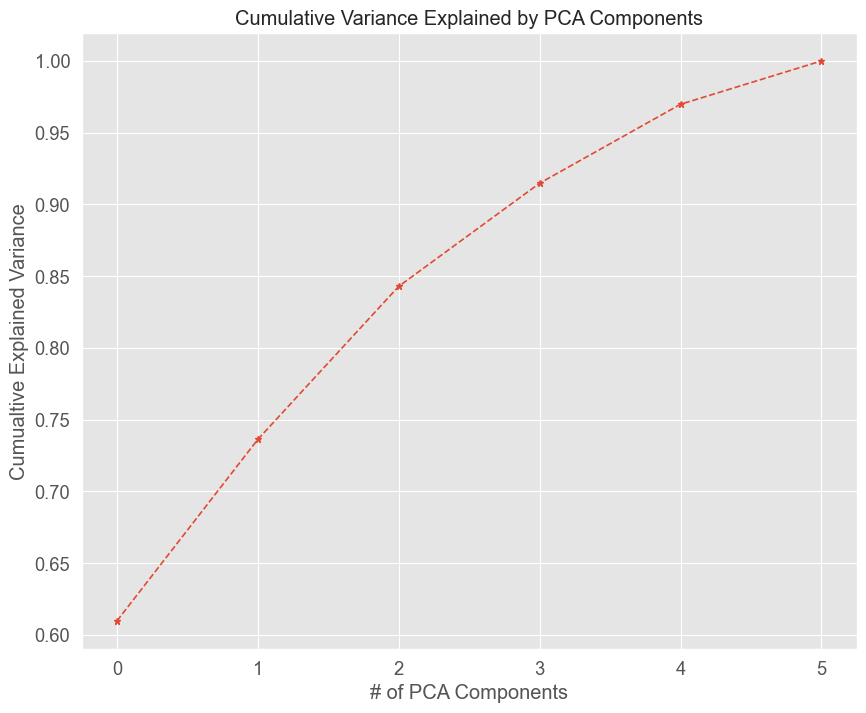

In [36]:
# Plot to figure out how many components to use in actual PCA model
plt.figure(figsize = (10,8))
plt.plot(range(0,6), pca.explained_variance_ratio_.cumsum(), marker = "*", linestyle = "--")
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel('# of PCA Components')
plt.ylabel('Cumualtive Explained Variance');

# Save figure
plt.savefig(save_path + '/CumVariancePCA_LINE.jpg')

### PCA Analysis

We can see from the cumulative explained variance graph above that after 3 components, there is a marginal increase in the percent of variance explained. Thus, to optimize the PCA model, we will use n_components = 3

In [37]:
pca = PCA(n_components=3, whiten=False)
x_pca = pca.fit_transform(x_vals)

# add features back into PCAdataframe (for plotting PCA)
df_supes['PCA 0'] = x_pca[:, 0]
df_supes['PCA 1'] = x_pca[:, 1]

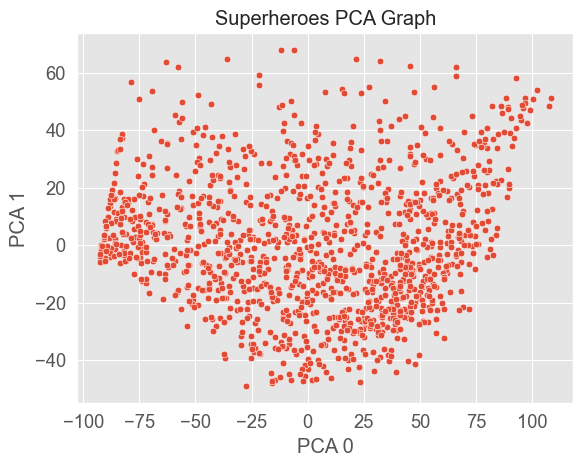

In [38]:
# Seaborn scatter plot for display
sns.scatterplot(data=df_supes, x="PCA 0", y="PCA 1").set(title='Superheroes PCA Graph');

# Save fig
plt.savefig(save_path + '/PCAPlot_SCT.jpg')

# 5.0: Machine Learning

## 5.0.1: K-Means Clustering

### General Clustering

In [39]:
# Optimize number of clusters
mean_d_dict = dict()
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x_pca)
    y = kmeans.predict(x_pca)    
        
    # compute & store mean distance
    mean_d = -kmeans.score(x_pca)
    mean_d_dict[n_clusters] = mean_d

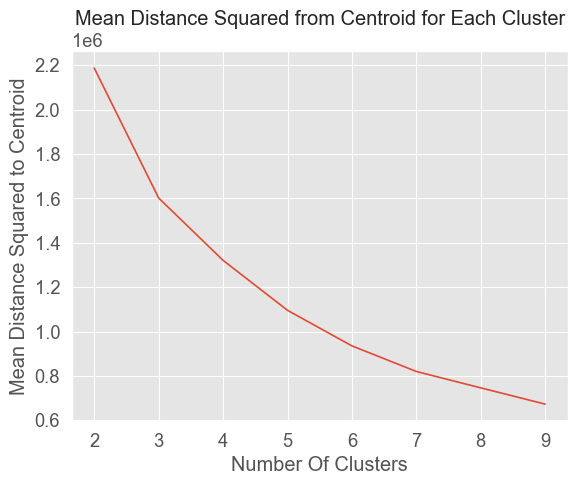

In [40]:
# Graph mean distance to centroid to find the optimal n-value
plt.plot(mean_d_dict.keys(), mean_d_dict.values())
plt.xlabel('Number Of Clusters')
plt.ylabel('Mean Distance Squared to Centroid');
plt.title('Mean Distance Squared from Centroid for Each Cluster');

# Save fig
plt.savefig(save_path + '/MeanD2Clusters_LINE.jpg')

We can see from the above graph comparing the mean distance squared from the centroid for each cluster decreases as the number of clusters increases. To optimize the K-Means Cluster algorithm, we must select the cluster at which the next decrease is marginal compared to the previous ones. However, there is no clear elbow in the graph above so no k will optimize our algorithm.

In [41]:
# X values are the features given in PCA y-axis
x = df_supes['PCA 0'].values.reshape(-1,1)

# Fit in KMeans algorithm
kmeans = KMeans(n_clusters=3)
kmeans.fit_transform(x)
y = kmeans.predict(x)

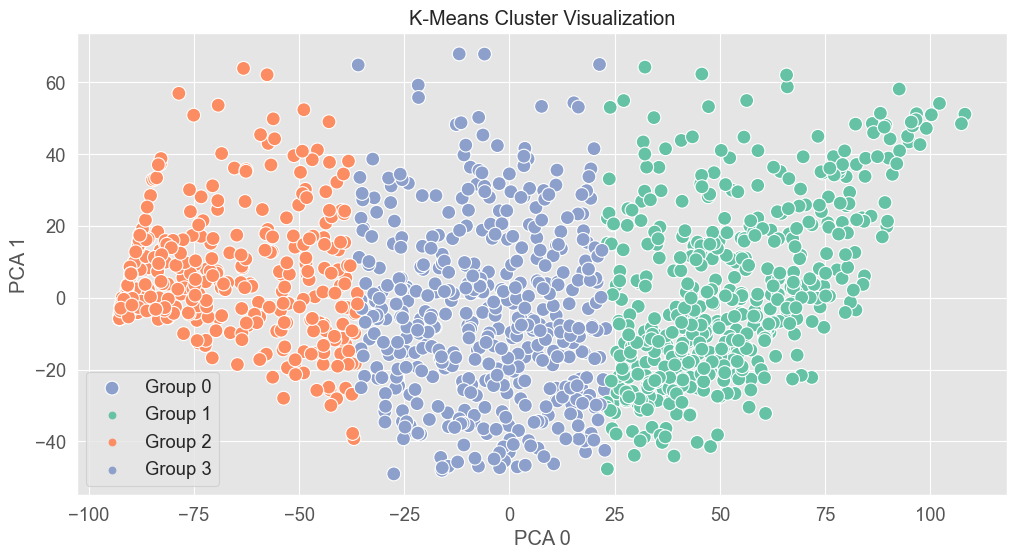

In [42]:
sns.scatterplot(data=df_supes, x='PCA 0', y='PCA 1', s=100, hue=y, palette='Set2')
plt.gcf().set_size_inches(12, 6)
plt.title('K-Means Cluster Visualization')
plt.legend([f"Group {i}" for i in range(0,6)])

# Save figure
plt.savefig(save_path + '/ClusterChart_SCT.jpg')

### Clustering Similar Superheroes


In [43]:
x_feat_list = ['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score', 'sentiment_score']

df_supes_similar = pd.DataFrame()

for feature in x_feat_list:
    df_supes_similar[f'{feature}'] = df_supes[feature] / df_supes[feature].std()

df_supes_similar.var()

intelligence_score    1.0
strength_score        1.0
speed_score           1.0
durability_score      1.0
power_score           1.0
combat_score          1.0
sentiment_score       1.0
dtype: float64

In [44]:
# Perform PCA on popular superheroes data
pca_popular = PCA(n_components=3, whiten=False)
x_pca_popular = pca_popular.fit_transform(df_supes_similar[x_feat_list])

# Add principal components back into dataframe
df_supes['PCA 0'] = x_pca_popular[:, 0]
df_supes['PCA 1'] = x_pca_popular[:, 1]

In [45]:
# Optimize number of clusters for popular superheroes
mean_d_dict = dict()
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x_pca_popular)
    y = kmeans.predict(x_pca_popular)    
        
    # Compute & Store mean distance
    mean_d = -kmeans.score(x_pca_popular)
    mean_d_dict[n_clusters] = mean_d

In [46]:
# Perform K-Means clustering on principal components
kmeans = KMeans(n_clusters=3)
df_supes['cluster'] = kmeans.fit_predict(x_pca_popular)

In [47]:
# Create scatterplot using Plotly Express
# fig = px.scatter(df_supes, x='PCA 0', y='PCA 1', color='cluster', hover_name='name')
# fig.update_layout(title='K-Means Cluster Similar Superheroes Visualization', legend_title='Cluster', 
#                     legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
# fig.show()

![Plotly Clustering](https://i.ibb.co/80cqhXG/Screenshot-2023-04-18-164422.jpg)

## 4.0.2: Classification

### Data Splitting & Model Training

In [48]:
comic_supes = df_supes[df_supes['creator'].str.contains('Comics')==True]

In [49]:
# We divide each feature by the standard deviation
df_supes_scaled = pd.DataFrame()
for feature in ['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score']:
    df_supes_scaled[f'{feature}'] = comic_supes[feature] / comic_supes[feature].std()

df_supes_scaled.var()

intelligence_score    1.0
strength_score        1.0
speed_score           1.0
durability_score      1.0
power_score           1.0
combat_score          1.0
dtype: float64

### KFold Cross Validation

In [50]:
k = 3

x_feat_list = ['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score']

y_feat = 'creator'

x = df_supes_scaled.loc[:, x_feat_list].values
y_true = comic_supes.loc[:, y_feat].values

# initializing a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

n_splits = 10

# construction of kfold object
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
        
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each bean's class
    y_pred[test_idx] = knn_classifier.predict(x_test)

### Confusion Matrix

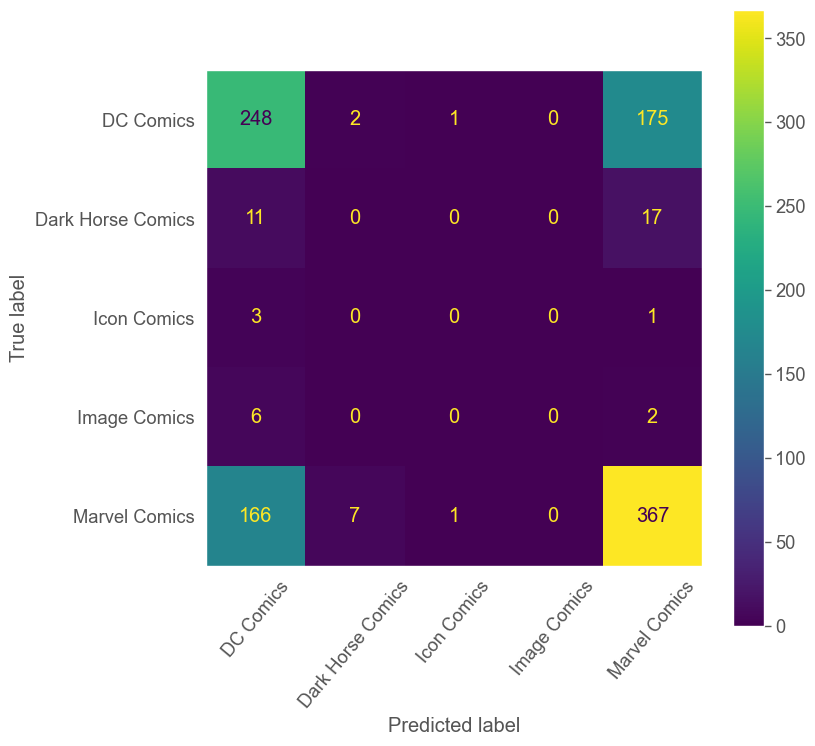

In [51]:
# The confusion matrix is made
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

# The confusion matrix display is made
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

conf_mat_disp.plot()
plt.gcf().set_size_inches(8, 8)
plt.grid(False)
plt.xticks(rotation=50)
# Save figure
plt.savefig(save_path + '/ConfMat.jpg')

In [52]:
# Computing the accuracy score of the confusion matrix
print("The accuracy of the model is " + str(round(accuracy_score(y_true, y_pred),3)*100) + "%")

The accuracy of the model is 61.1%


## 4.0.3: Decision Tree Regressor

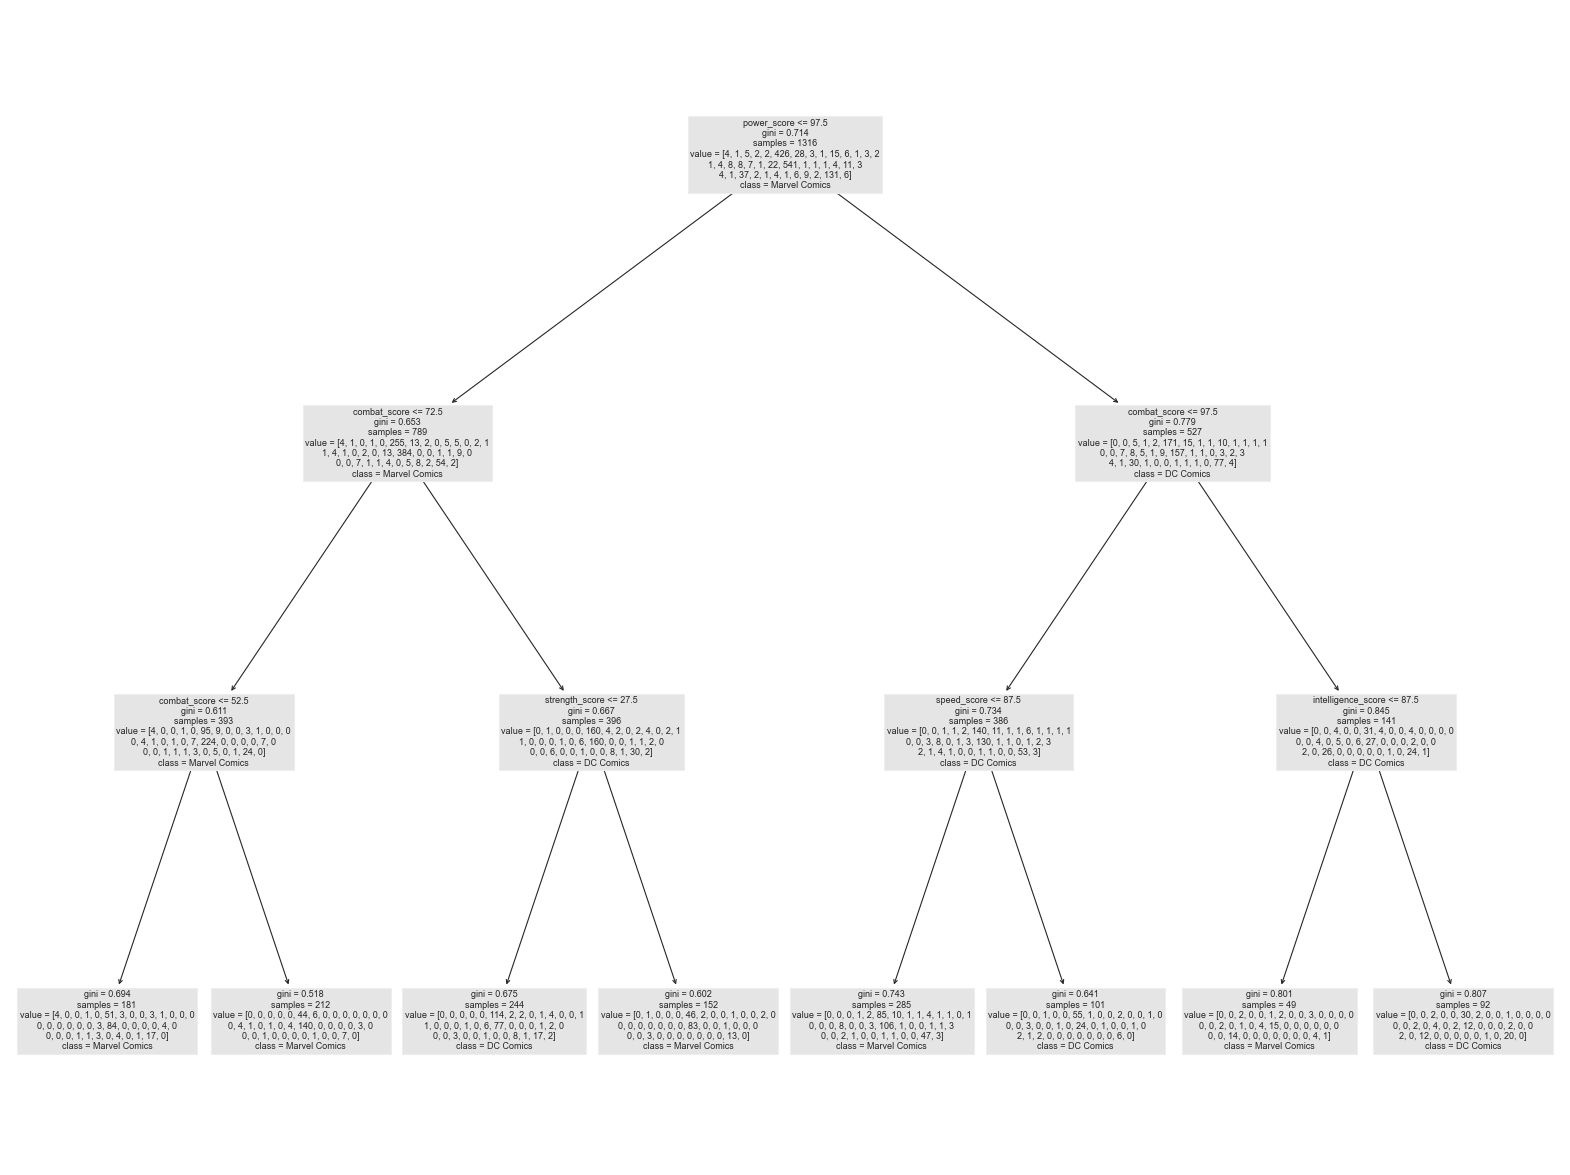

In [53]:
max_depth = 3
x_feat_list = ['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 'power_score', 'combat_score']

#extracting data from dataframe
x = df_supes.loc[:, x_feat_list].values
y = df_supes.loc[:, 'creator'].values

#build decision tree classifier 
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

# fit data
dec_tree_clf.fit(x, y)                                         
    
# initialize empty figure (plot_tree sets text size to fill given figure
# if we resize figure afterwards text size remains too small)
plt.figure()
plt.gcf().set_size_inches(20, 15)
        
# 'plot' decision tree
tree.plot_tree(dec_tree_clf,
               feature_names=x_feat_list,
               class_names=dec_tree_clf.classes_);

## 4.0.4: Random Forest Regressor

In [54]:
x_feat_list =  ['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 'combat_score', 'power_score']

#extracting data from dataframe
x = df_supes.loc[:, x_feat_list].values
y = df_supes.loc[:, 'overall_score'].values

n_splits = 10

#build Random Forest Regressor  
randomforest_rg = RandomForestRegressor()

# construction of kfold object
skfold = KFold(n_splits=n_splits, shuffle=True)

# allocate an empty array to store predictions in
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    #get training data 
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    #get test data
    x_test = x[test_idx, :]
    
    # fit data 
    randomforest_rg = randomforest_rg.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = randomforest_rg.predict(x_test)

#compute r2 score 
r2 = r2_score(y_true=y, y_pred=y_pred)
r2

0.26811967487312915

In [55]:
x_feat_list =  ['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 'combat_score', 'power_score']

#eextracting data from dataframe
x = df_supes.loc[:, x_feat_list].values
y = df_supes.loc[:, 'overall_score'].values

#construct regressor 
rf_rg = RandomForestRegressor(n_estimators=100)

#fit data 
rf_rg.fit(x, y)

RandomForestRegressor()

In [56]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across RandomForestRegressor)')

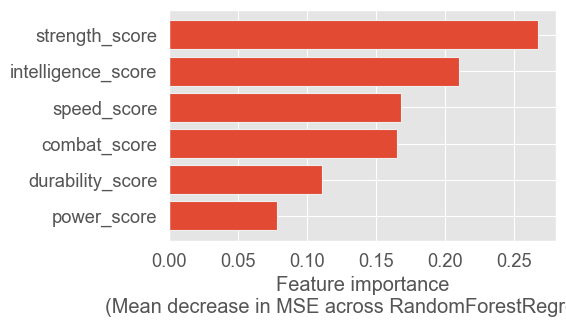

In [57]:
#plot the feature importance graph 
plot_feat_import(x_feat_list, rf_rg.feature_importances_)

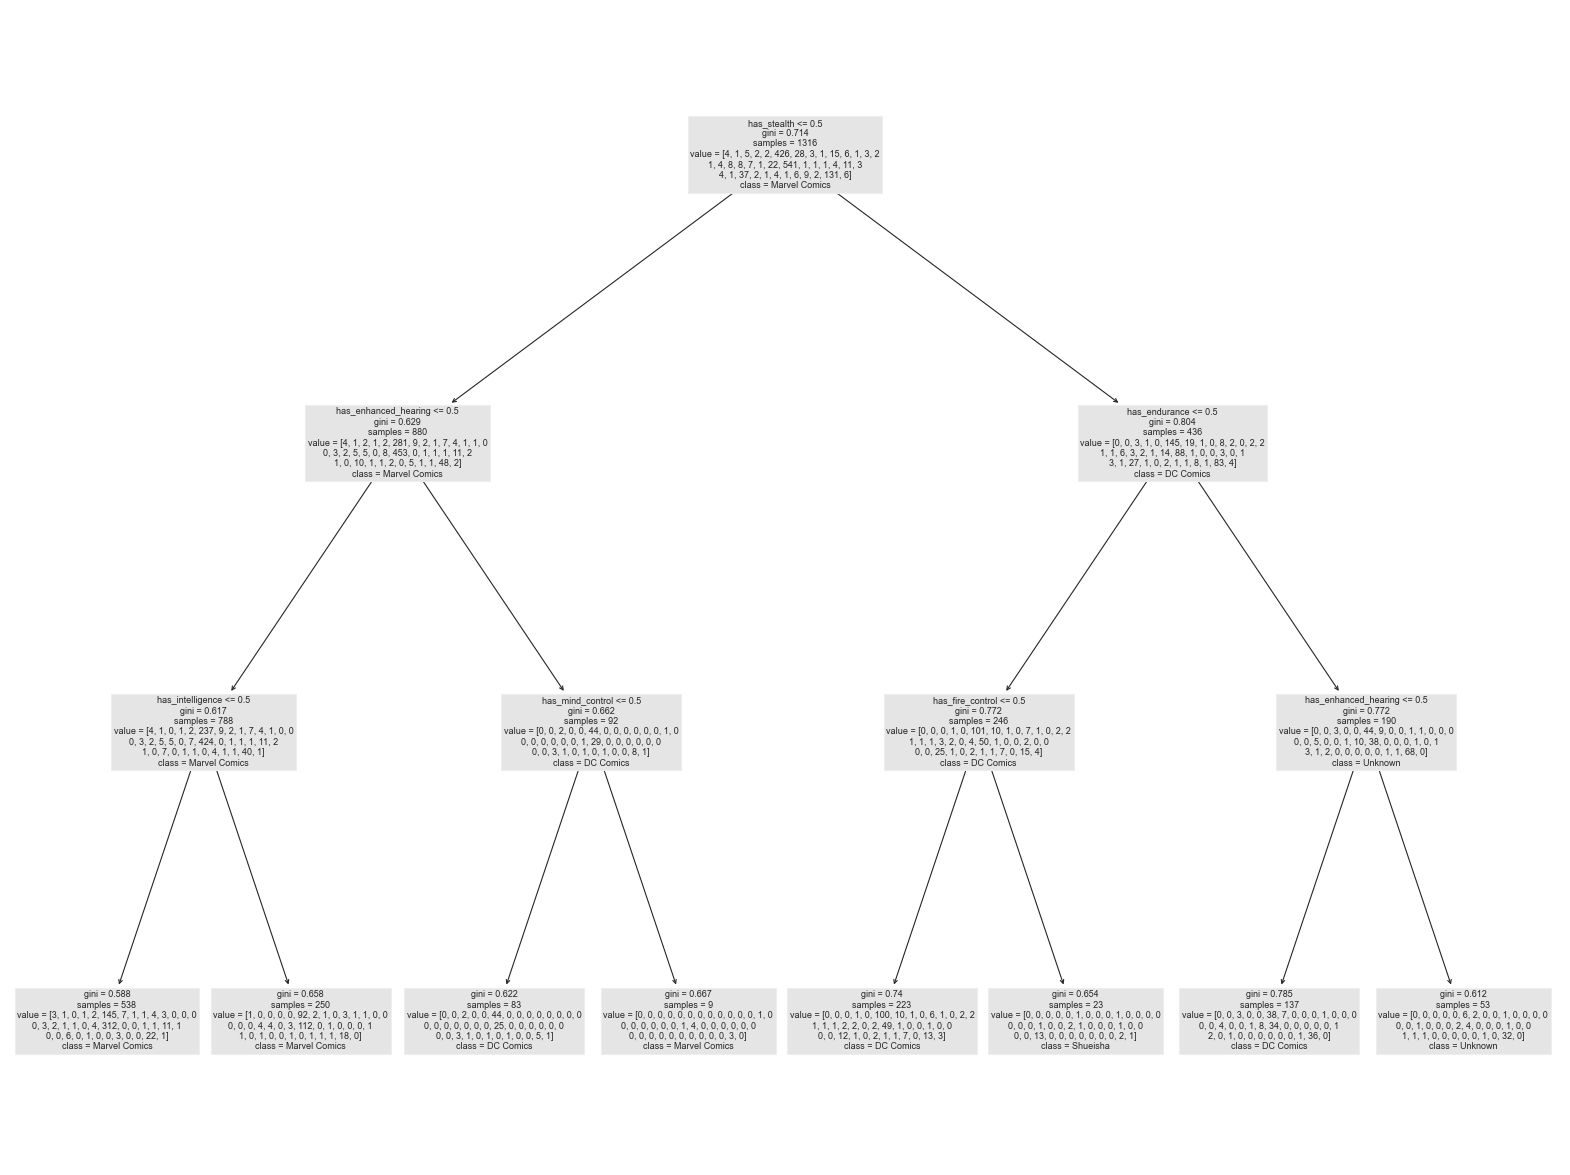

In [58]:
max_depth = 3
x_feat_list = ['has_mind_control', 'has_enhanced_hearing', 'has_element_control', 'has_size_changing','has_fire_control', 'has_reality_warping', 'has_energy_beams','has_shapeshifting', 'has_jump', 
               'has_self-sustenance', 'has_energy_absorption', 'has_magic', 'has_telekinesis', 'has_telepathy', 'has_regeneration','has_immortality', 'has_teleportation', 'has_force_fields',
               'has_energy_manipulation', 'has_endurance', 'has_weapon-based_powers', 'has_energy_blasts', 'has_enhanced_senses', 'has_invulnerability', 'has_stealth', 'has_flight', 'has_accelerated_healing',
               'has_weapons_master', 'has_intelligence','has_reflexes', 'has_super_speed', 'has_durability', 'has_stamina','has_agility', 'has_super_strength']

#extracting data from dataframe
x = df_supes.loc[:, x_feat_list].values
y = df_supes.loc[:, 'creator'].values

#build decision tree classifier 
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

# fit data
dec_tree_clf.fit(x, y)                                         
    
# initialize empty figure (plot_tree sets text size to fill given figure
# if we resize figure afterwards text size remains too small)
plt.figure()
plt.gcf().set_size_inches(20, 15)
        
# 'plot' decision tree
tree.plot_tree(dec_tree_clf,
               feature_names=x_feat_list,
               class_names=dec_tree_clf.classes_);

# 5.0: Recommendation System

In [59]:
def get_scores(name, idx):
    """
    Function that retrieves a dictionary of scores for a superhero based on their name.

    Args:
        name (str): The name of the superhero to retrieve scores for.
        idx (int): The index of the superhero in the dataframe.

    Returns:
        score_dict (dict): A dictionary of scores for the superhero with the specified name.
    """
    score_dict = {}
    for col in num_cols:
        score_dict[col] = df_supes.loc[idx, col]
    return score_dict

In [60]:
# Define the columns to include in the recommendation system
text_cols = ["powers_text", "history_text", "creator", "alignment"]

num_cols = ["intelligence_score", "strength_score", "speed_score", "durability_score", "combat_score", "power_score", 'has_mind_control', 'has_enhanced_hearing', 'has_element_control', 'has_size_changing',
            'has_fire_control', 'has_reality_warping', 'has_energy_beams','has_shapeshifting', 'has_jump', 
               'has_self-sustenance', 'has_energy_absorption', 'has_magic', 'has_telekinesis', 'has_telepathy', 'has_regeneration','has_immortality', 'has_teleportation', 'has_force_fields',
               'has_energy_manipulation', 'has_endurance', 'has_weapon-based_powers', 'has_energy_blasts', 'has_enhanced_senses', 'has_invulnerability', 'has_stealth', 'has_flight', 'has_accelerated_healing',
               'has_weapons_master', 'has_intelligence','has_reflexes', 'has_super_speed', 'has_durability', 'has_stamina','has_agility', 'has_super_strength', 'sentiment_score']

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the values in num_cols
df_supes[num_cols] = scaler.fit_transform(df_supes[num_cols])

# Concatenate the text and numerical columns
df_supes["combined_text"] = df_supes[text_cols].apply(lambda x: " ".join(x), axis=1) + " " + df_supes[num_cols].astype(str).apply(lambda x: " ".join(x), axis=1)


# Fit TfidfVectorizer to the combined text column
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_supes["combined_text"])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

def get_recommendations(name, tolerance, cosine_sim=cosine_sim):
    """
    Function that recommends similar superheroes based on the numerical scores of a given superhero and a specified tolerance.

    Args:
        name (str): The name of the superhero to get recommendations for.
        tolerance (float): The tolerance for similarity between the scores of the specified superhero and the recommended superheroes
        cosine_sim (numpy.ndarray): The cosine similarity matrix to use for recommendations

    Returns:
        pandas.Series: A pandas Series containing the names of the recommended superheroes.
    """
    idx = df_supes[df_supes["name"] == name].index[0]
    score_dict = get_scores(name, idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:4]
    superhero_indices = [i[0] for i in sim_scores]
    
    # Filter by similar numerical scores
    similar_indices = []
    for i in superhero_indices:
        similar = True
        for col, value in score_dict.items():
            if not (value - tolerance <= df_supes.loc[i, col] <= value + tolerance):
                similar = False
                break
        if similar:
            similar_indices.append(i)

    return df_supes["name"].iloc[similar_indices]

In [61]:
# Get recommendations for a specific superhero
get_recommendations("Spider-Man (Raimi Trilogy)", tolerance=1)

517    Harry Osborn (Raimi Trilogy)
494                 Green Goblin II
917                  Peter Petrelli
Name: name, dtype: object